In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import geopandas as gpd

# Los Angeles Crime from 2020 to present

## Data Sources

* [LA City Crime Dataset](https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8/about_data)
* [LA City Geographical Dataset](https://geohub.lacity.org/datasets/19a8293551974116b76533e984dd9260/about)

## Executive Summary
This project analyzes crime data from Los Angeles from 2020 to the present to identify patterns, trends, and actionable insights for improving public safety. Leveraging Python, the analysis focuses on crime frequency, weapon use, victim demographics, and spatial-temporal patterns. The study finds that property crimes are the most prevalent, with certain areas experiencing higher crime rates than others. Insights from this project inform law enforcement resource allocation, public safety campaigns, and crime prevention strategies. Future studies can enhance these findings by integrating socio-economic factors and predictive analytics.

#### About the data
The data set has more than 900,000 rows of information provided by the Los Angeles Police Department. This data contains information about crime in Los Angeles from 2020 to present, such as, reported crimes, victim ages, and statuses of the investigations.

## Questions:
1. What are the most common crimes reported? (Top 10)
2. What weapons were used in the crimes reported? (Top 10)
3. What areas have the most amount of reported crime? (Top 10)
4. What time of day are the most amount of reported crimes occuring?
5. What day of the week has the most reported crime?
6. What were the victims' sexes?
7. What age groups did the victims belong to?
8. How does the count of victims change with age and sex?
9. What are the victims' descent?
10. What are the statuses of the reported crime?
11. What year had the most crime?

## Data Setup

Run this section before anything else

In [2]:
# Reading in the data
lacrime_df= pd.read_csv("C:/Users/perez/Downloads/Crime_Data_from_2020_to_Present_2024.csv")

# Dropping columns of information that aren't used in this analysis
lacrime_df.drop(['Crm Cd 1','Crm Cd 2','Crm Cd 3','Crm Cd 4','Cross Street','Status',
                 'LAT','LON','Weapon Used Cd','Mocodes','Part 1-2'],axis=1,inplace=True)

In [3]:
# Adjusting Victim Sex column to fill in unknowns and nonapplicables with 'X'
lacrime_df['Vict Sex']=lacrime_df['Vict Sex'].replace('H','X')
lacrime_df['Vict Sex']=lacrime_df['Vict Sex'].replace('-','X')
lacrime_df['Vict Sex']= lacrime_df['Vict Sex'].fillna('X')
lacrime_df['Vict Sex']=lacrime_df['Vict Sex'].replace('F','Female')
lacrime_df['Vict Sex']=lacrime_df['Vict Sex'].replace('M','Male')
lacrime_df['Vict Sex']=lacrime_df['Vict Sex'].replace('X','Unknown/Nonapplicable')

In [4]:
# Adjusting Victim Descent column to fill in unknowns and nonapplicables with 'X'
lacrime_df['Vict Descent']= lacrime_df['Vict Descent'].replace('-','X')
lacrime_df['Vict Descent']= lacrime_df['Vict Descent'].fillna('X')

# Replacing shorthand descent code with actual descent name as defined by LAPD
replacements={'H':'Hispanic/Latin/Mexican','B':'Black','W':'White','A':'Other Asian','K':'Korean','C':'Chinese','F':'Filipino',
             'J':'Japanese','I':'American Indian/Alaskan Native','V':"Vietnamese",'S':'Samoan','P':'Pacific Islander',
             'Z':'Asian Indian','G':'Guamanian','U':'Hawaiian','D':'Cambodain','L':'Laotian','X':'Unknown','O':'Other'}
lacrime_df['Vict Descent']= lacrime_df['Vict Descent'].replace(replacements)

In [5]:
def timeofday(time):
    occ= time    
    if time >=0 and time <600:
        return 'Late night: 12am to 6am'
    if time >=600 and time <1200:
        return 'Morning: 6am to 12pm'
    if time >=1200 and time <1800:
        return 'Afternoon: 12pm to 6pm'
    if time >=1800 and time <2359:
        return 'Evening/Night: 6pm to 12am'       
# Using the function to add a new column containing time of day from time crime occurred
lacrime_df['Time Crime Occ']= lacrime_df['TIME OCC'].apply(timeofday)

In [6]:
# Adding a new column, day of the week the crime occurred
lacrime_df['DATE OCC']= pd.to_datetime(lacrime_df['DATE OCC'], format="%m/%d/%Y %I:%M:%S %p")
lacrime_df['Day of the Week']=lacrime_df['DATE OCC'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
lacrime_df['Day of the Week'] = pd.Categorical(lacrime_df['Day of the Week'], categories=weekday_order, ordered=True)

In [7]:
# Adding a new column, year crime occurred
lacrime_df['Year']= pd.DatetimeIndex(lacrime_df['DATE OCC']).year

In [8]:
# Finding instances where age is 0 or less and crime description contains 'child', 'minor', or 'chld'
# and replacing age with -7, an arbritrary number, as specific age can't be inferred but age group can
lacrime_df.loc[(lacrime_df['Vict Age'] <=0 )&(lacrime_df['Crm Cd Desc'].str.contains(r'chld|child|minor', case=False, na=False)),'Vict Age']= -7

In [9]:
def agegroup(victim):
    age= victim    
    if age == -7 or age <18 and age > 0:
        return 'Minors: 0 to 17 y/o'
    if age > 17 and age < 27:
        return 'Young Adults:18 to 26 y/o'
    if age < 1:
        return 'X'
    if age < 55 and age >26:
        return 'Adults: 27 to 54 y/o'
    else:
        return 'Seniors: 55+ y/o'
# Using the function to add a new column Age Group from victim age
lacrime_df['Age Group']=lacrime_df['Vict Age'].apply(agegroup)
ageorder=['Minors: 0 to 17 y/o','Young Adults:18 to 26 y/o','Adults: 27 to 54 y/o','Seniors: 55+ y/o']

In [10]:
# Creating a new data frame age1 grouping victims by age and sex, and including count
age1= lacrime_df.groupby(['Vict Age','Vict Sex']).size().reset_index(name='count')
age1= age1[(age1['Vict Age']>0) & (age1['Vict Sex'] != 'X')]

# Finding certain points on the lineplot
# Separating the data by sex
female_data= age1[age1['Vict Sex'] == 'Female'][['Vict Age','count']].rename(columns={'count':'female_count'})
male_data= age1[age1['Vict Sex'] == 'Male'][['Vict Age','count']].rename(columns={'count':'male_count'})

# Merging the datasets on 'Vict Age'
merged_data= pd.merge(female_data, male_data,on='Vict Age',how='inner')

# Finding male peaks
male_peaks, _= find_peaks(merged_data['male_count'],threshold=500)
male_peak_values= merged_data.iloc[male_peaks][['Vict Age','male_count']]

# Finding the maximum for female count
female_max_value= merged_data.loc[merged_data['female_count'].idxmax()]

In [11]:
# Reading in geodata for the 21 patrol divisions
lapd= gpd.read_file("C:/Users/perez/Downloads/LAPD_Reporting_Districts.geojson")

# Getting rid of columns that won't be used
lapd= lapd[['APREC','geometry']]

# Replacing column name to match la crime data column name
lapd.rename(columns={'APREC':'AREA NAME'}, inplace=True)

# Dissolving borders to have 21 patrol divisions
lapd = lapd.dissolve(by='AREA NAME')
lapd.reset_index(inplace=True)

# Replacing 21 patrol division names to match la crime data names
update_areas= {'PACIFIC':'Pacific','DEVONSHIRE':'Devonshire','WEST LOS ANGELES':'West LA','NORTHEAST':'Northeast',
'HOLLENBECK':'Hollenbeck','MISSION':'Mission','FOOTHILL':'Foothill', 'NORTH HOLLYWOOD':'N Hollywood','SOUTHWEST': 'Southwest',         
'WILSHIRE':'Wilshire','TOPANGA':'Topanga','OLYMPIC':'Olympic','CENTRAL':'Central', 'WEST VALLEY':'West Valley', 'HARBOR':'Harbor',           
'NEWTON':'Newton', 'RAMPART':'Rampart','VAN NUYS':'Van Nuys','77TH STREET':'77th Street','HOLLYWOOD':'Hollywood','SOUTHEAST':'Southeast'}  
lapd.replace(update_areas,inplace=True)

In [12]:
# Creating new dataframe by area name and count, the count will be the density on the map
areas= lacrime_df.groupby(['AREA NAME']).size().reset_index(name='count').sort_values(by='count', ascending=False)

# Merging lapd and areas into one dataframe
lapdareas= lapd.merge(areas, on='AREA NAME')

# Ordering areas from highest count to lowest count
lapdareas.sort_values(by='count',ascending=False, inplace=True)

# Adding new column Rank to rank areas from highstest count to lowest count
lapdareas['Rank']= range(1,len(lapdareas)+1)

## Findings
This section contains the answers to the questions posed.

### Question 1: What are the most common crimes reported? (Top 10)

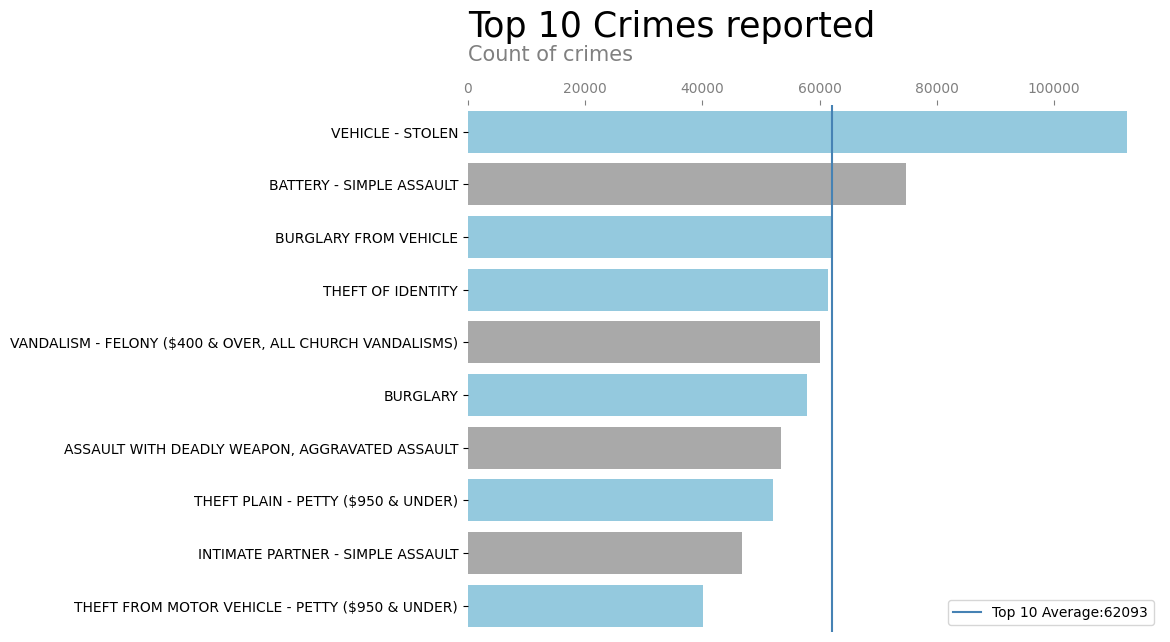

In [13]:
crimes = lacrime_df.pivot_table(index='Crm Cd Desc',
                                aggfunc='size').reset_index(name='Number of cases').sort_values(by='Number of cases',ascending=False)
hl= ['VEHICLE - STOLEN','BURGLARY FROM VEHICLE','THEFT OF IDENTITY','BURGLARY',
     'THEFT PLAIN - PETTY ($950 & UNDER)','THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)']
crimes['Color Group'] = ['Highlight' if cat in hl else 'Normal' for cat in crimes['Crm Cd Desc']]
q1= sns.catplot(data=crimes.head(10), x='Number of cases',y='Crm Cd Desc', height=6,aspect=2,kind='bar',hue='Color Group',
                palette={'Highlight': 'skyblue', 'Normal': 'darkgrey'},legend=False)
plt.title("Top 10 Crimes reported",fontsize=25,loc='left')
q1.set(ylabel=None)
q1.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False,color='grey',labelcolor='grey')
for ax in q1.axes.flat:
    ax.set_xlabel('Count of crimes', fontsize=15, labelpad=15,loc='left',color='grey')
    ax.xaxis.set_label_position('top')
sns.despine(left=True, bottom=True)
averagec= round(crimes['Number of cases'].head(10).mean())
plt.axvline(averagec, color='steelblue', linestyle='-', label=f'Top 10 Average:{averagec}')
plt.legend()
plt.show()

#### Description
The data shows that certain types of offenses, such as theft and assault, are more common. Six of the top ten crimes involve some sort of thievery, and highlights an overall trend in LA. This information could inform LAPD where increased preventative measures could be beneficial.

### Question 2: What weapons were used in the crimes reported (Top 10)

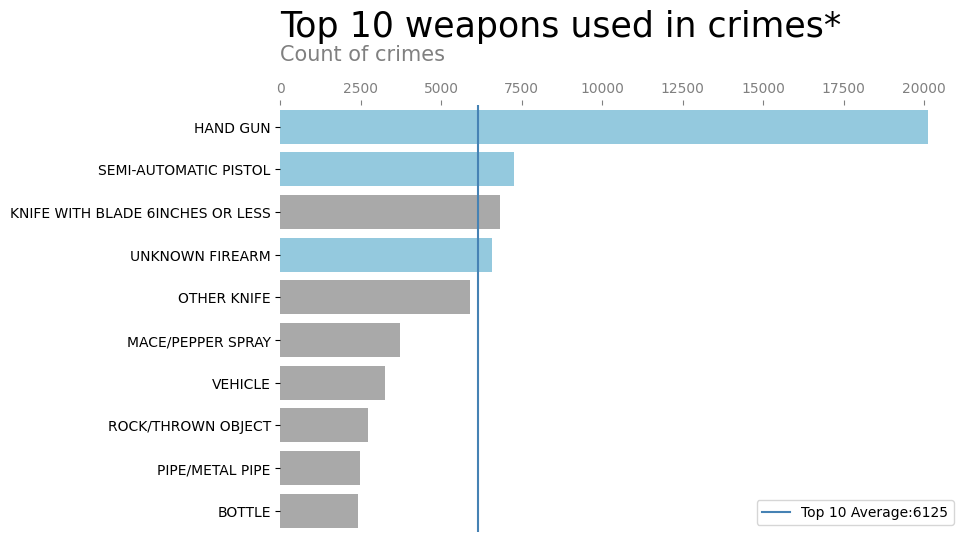

In [14]:
weaponsx= lacrime_df.pivot_table(index='Weapon Desc', aggfunc='size').reset_index(name='count').sort_values('count',ascending=False)
weaponsx = weaponsx[(weaponsx['Weapon Desc'] !=
                     'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)') &(weaponsx['Weapon Desc'] !='VERBAL THREAT'
                     )&(weaponsx['Weapon Desc'] != 'UNKNOWN WEAPON/OTHER WEAPON')].head(10)
hl= ['HAND GUN','SEMI-AUTOMATIC PISTOL','UNKNOWN FIREARM']
weaponsx['Color Group'] = ['Highlight' if cat in hl else 'Normal' for cat in weaponsx['Weapon Desc']]
q2= sns.catplot(data=weaponsx.head(10), y='Weapon Desc', x='count',hue='Color Group',kind='bar',height=5,aspect=2,
                palette={'Highlight': 'skyblue', 'Normal': 'darkgrey'},legend=False)
plt.title("Top 10 weapons used in crimes*",fontsize=25,loc='left')
q2.set(ylabel=None)
q2.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False,color='grey',labelcolor='grey')
for ax in q2.axes.flat:
    ax.set_xlabel('Count of crimes', fontsize=15, labelpad=15,loc='left',color='grey')
    ax.xaxis.set_label_position('top')
sns.despine(left=True, bottom=True)
averagewx= round(weaponsx['count'].head(10).mean())
plt.axvline(averagewx, color='steelblue', linestyle='-', label=f'Top 10 Average:{averagewx}')
plt.legend()
plt.show()

#### Description

This chart highlights patterns in weapon use, with firearms and knives being the most frequently involved. Three of the top ten weapons used are some sort of firearm, this information can aid the LAPD in tailoring responses and interventions, such as increased firearm regulation or targeted law enforcement strategies. 
<br>
*Verbal threats, strong-arm, incidents as those involving hands, fists, feet or bodily force, and unknown weapons were not included in this analysis due to their broader and less quantifiable nature.

### Question 3: What areas have the most amount of reported crime? (Top 10)

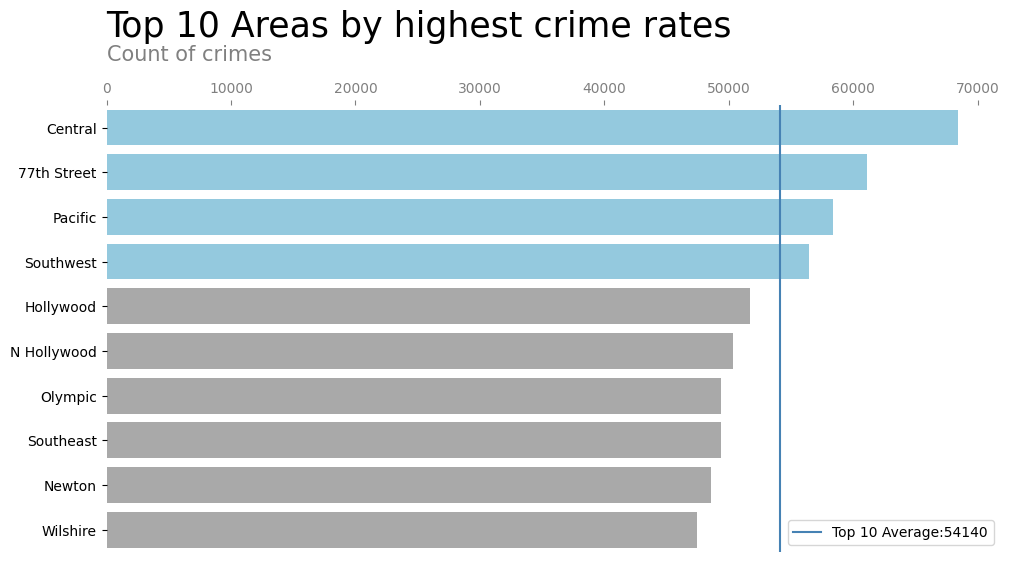

In [15]:
hl= ['Central','77th Street','Pacific','Southwest']
areas['Color Group'] = ['Highlight' if cat in hl else 'Normal' for cat in areas['AREA NAME']]
q3= sns.catplot(data=areas.head(10),x='count', y='AREA NAME',hue='Color Group',height=5.2,aspect=2,kind='bar',
                               palette={'Highlight': 'skyblue', 'Normal': 'darkgrey'},legend=False)
plt.title('Top 10 Areas by highest crime rates',fontsize=25,loc='left')
plt.xlabel('Count of crimes',fontsize=15)
q3.set(ylabel=None)
q3.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False,color='grey',labelcolor='grey')
for ax in q3.axes.flat:
    ax.set_xlabel('Count of crimes', fontsize=15, labelpad=15,loc='left',color='grey')
    ax.xaxis.set_label_position('top')
sns.despine(left=True, bottom=True)
averagea= round(areas['count'].head(10).mean())
plt.axvline(averagea, color='steelblue', linestyle='-', label=f'Top 10 Average:{averagea}')
plt.legend()
plt.show()

#### Description
This chart highlights the top 10 areas with the highest crime rates in LA. Four of these areas stand out as having crime rates above the top 10 average. This highlights potential areas for focused intervention and analysis to better understand the contributing factors to these elevated crime rates.

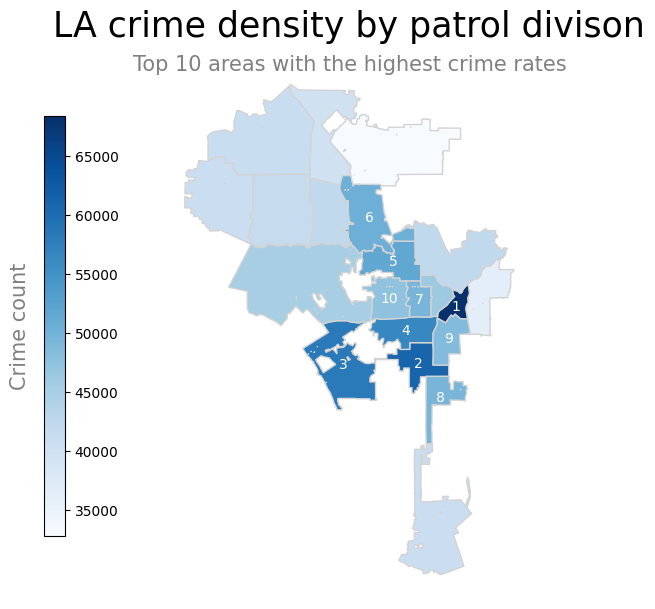

In [16]:
lapdareas= lapdareas.to_crs(epsg=2229)
ax= lapdareas.plot(column='count', legend=True,figsize=(7,7),cmap='Blues',edgecolor='lightgrey')
for x, y, label in zip(lapdareas.geometry.centroid.x, lapdareas.geometry.centroid.y, lapdareas['Rank'][lapdareas['Rank']<11]):
    plt.text(x, y, label, ha='center', va='center',color='white')
ax.set_title('LA crime density by patrol divison', fontsize=25)
ax.text(0.5, .98, 'Top 10 areas with the highest crime rates', 
        fontsize=15, color='grey',ha='center', transform=ax.transAxes)
cbar = ax.get_figure().get_axes()[1]
cbar.set_position([0.05, 0.15, 0.03, 0.7])
cbar.yaxis.set_label_position('left')
cbar.set_ylabel('Crime count', fontsize=15, labelpad=10,color='grey')
plt.axis('off')
plt.show()

#### Description
The LAPD has 21 geographical areas know as patrol divisions. This data identifies crime hotspots, indicating where resource allocation for policing and community programs could be most impactful. An interesting observation is that most of the top 10 crime areas are geopraphically clustered.

### Question 4: What time of day are the most amount of reported crimes occuring?

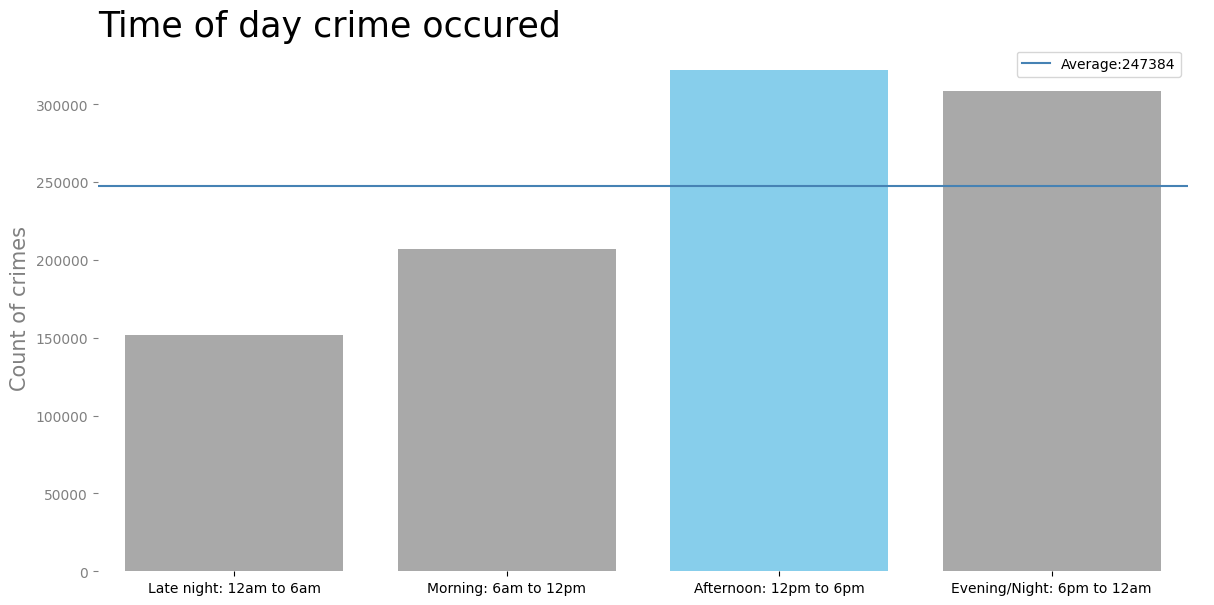

In [17]:
timeorder= ['Late night: 12am to 6am','Morning: 6am to 12pm','Afternoon: 12pm to 6pm','Evening/Night: 6pm to 12am']
q4= sns.catplot(data=lacrime_df,x='Time Crime Occ',kind='count',height=6,aspect=2,order=timeorder,color='darkgrey')
afternoon_bar = q4.ax.patches[2] 
afternoon_bar.set_facecolor('skyblue')
plt.title('Time of day crime occured',fontsize=25,loc='left')
plt.ylabel('Count of crimes',fontsize=15,color='grey')
q4.tick_params(axis='y',colors='grey')
qq4 = q4.ax
qq4.spines['left'].set_color("grey")  # Changes the vertical line (y-axis)
q4.set(xlabel=None)
sns.despine(bottom=True,left=True)
averagepd= round(lacrime_df['Time Crime Occ'].value_counts().mean())
plt.axhline(averagepd,color='steelblue',linestyle='-',label=f'Average:{averagepd}')
plt.legend()
plt.show()

#### Description

The data indicates the highest spike in crimes during the afternoon hours, with night hours following right behind. This can help  inform strategies around lighting, patrols, or community awareness initiatives during high-crime hours. There is a potential to divided the days in short timeframes and highlight more specific peaks in crimes reported.

### Question 5: What day of the week has the most reported crime?

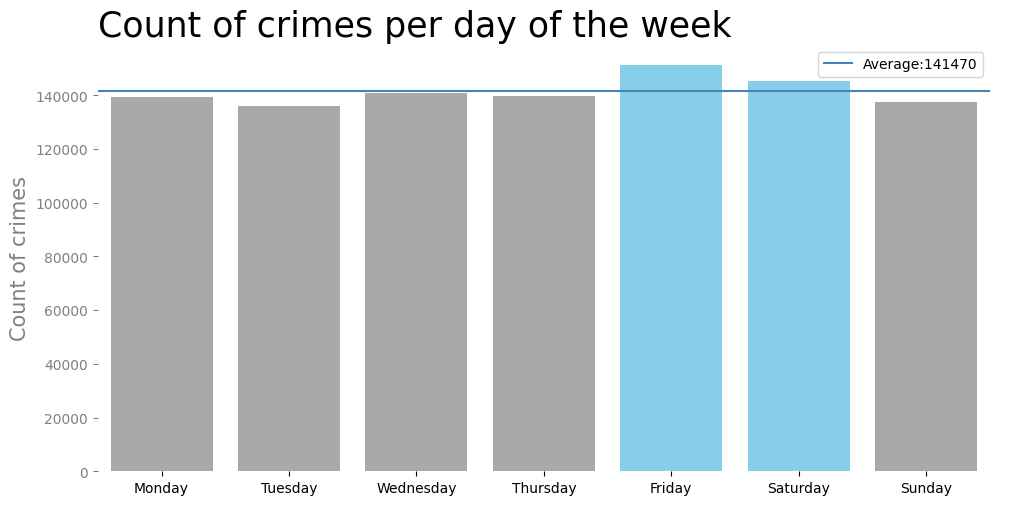

In [18]:
q5= sns.catplot(data=lacrime_df,x='Day of the Week',kind='count',height=5,aspect=2,color='darkgrey')
fri = q5.ax.patches[4] 
sat = q5.ax.patches[5]  
fri.set_facecolor('skyblue')
sat.set_facecolor('skyblue')
plt.title('Count of crimes per day of the week',fontsize=25,loc='left')
plt.ylabel('Count of crimes',fontsize=15,color='grey')
q5.tick_params(axis='y',colors='grey')
qq5 = q5.ax
qq5.spines['left'].set_color("grey")
q5.set(xlabel=None)
sns.despine(bottom=True,left=True)
averagedw= round(lacrime_df['Day of the Week'].value_counts().mean())
plt.axhline(averagedw,color='steelblue',linestyle='-',label=f'Average:{averagedw}')
plt.legend()
plt.show()

#### Description
Fridays and Saturdays may see increased crime rates, potentially linked to social behavior or events. These insights can guide police shifts or community activities aimed at crime prevention on specific days.

### Question 6: What were the victims' sexes?

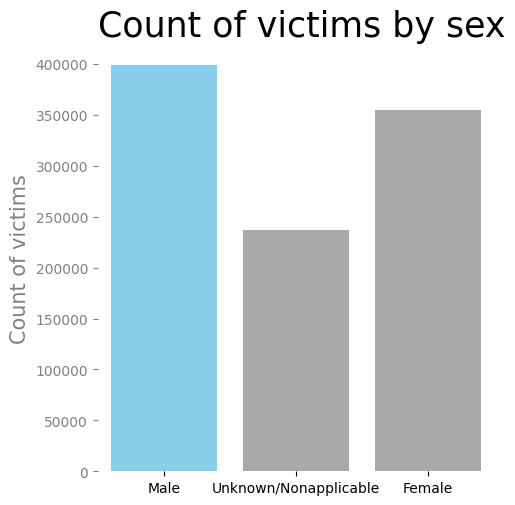

In [19]:
q6= sns.catplot(data=lacrime_df, x='Vict Sex',kind='count',color='darkgrey')
plt.title('Count of victims by sex',fontsize=25,loc='left')
male = q6.ax.patches[0]  
male.set_facecolor('skyblue')
q6.tick_params(axis='y',colors='grey')
qq6 = q6.ax
qq6.spines['left'].set_color("grey")
q6.set(xlabel=None)
sns.despine(bottom=True,left=True)
plt.ylabel('Count of victims',fontsize=15,color='grey')
plt.show()

#### Description

The data shows that males are more often the victims of crime in LA. It's interesting to see that there is a big percentage of unkown or nonapplicable victims.

### Question 7: What age groups did the victims belong to?

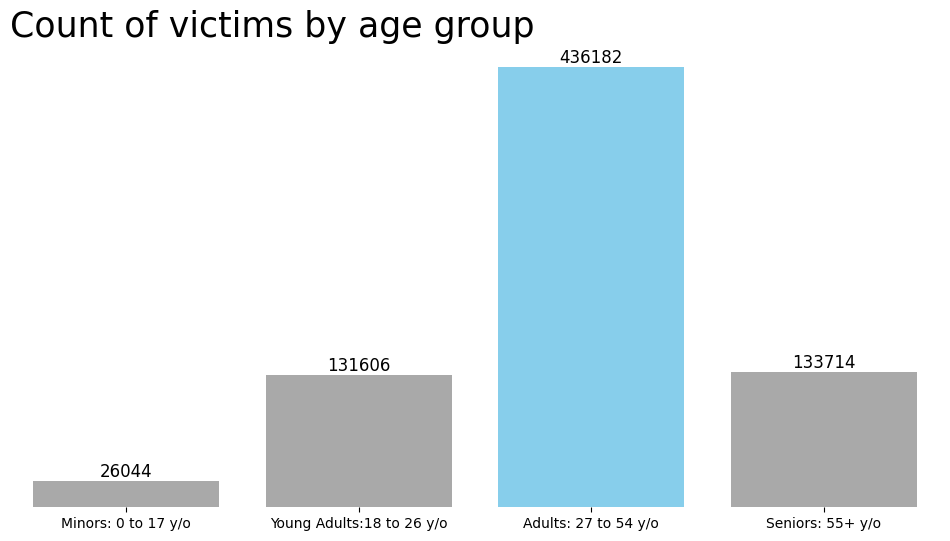

In [20]:
plt.figure(figsize=(12, 6))
q7= sns.countplot(data=lacrime_df[lacrime_df['Age Group'] != 'X'], x='Age Group',order=ageorder,color='darkgrey')
plt.title('Count of victims by age group',fontsize=25,loc='left')
adult_bar = q7.patches[2] 
adult_bar.set_facecolor('skyblue')
sns.despine(left=True,bottom=True)
q7.set(xlabel=None)
q7.set(ylabel=None)
plt.yticks(ticks=[], labels=[])
for p in q7.patches:  
    q7.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 2, 
            f'{int(p.get_height())}', 
            ha='center', va='bottom', fontsize=12)
plt.show()

#### Description
The data reveals that adults experience the highest rate of victimhood.

### Question 8: How does the count of victims change with age and sex?

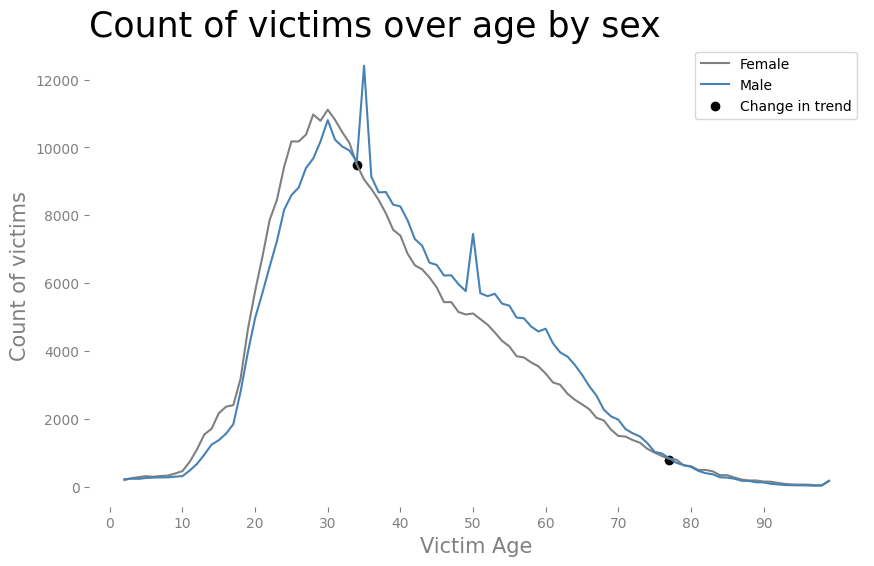

In [76]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='Vict Age', y='female_count', label='Female',color='grey')
sns.lineplot(data=merged_data, x='Vict Age', y='male_count', label='Male',color='steelblue')
#plt.scatter(male_peak_values['Vict Age'], male_peak_values['male_count'], color='orange', label='Male Peaks')
#plt.scatter(female_max_value['Vict Age'], female_max_value['female_count'], color='purple', label='Female Max', marker='o')
plt.scatter(34,9497, color='black', label='Change in trend')
plt.scatter(77,795, color='black')
plt.title('Count of victims over age by sex', fontsize=25,loc='left')
plt.xlabel('Victim Age',fontsize=15,color='grey')
plt.ylabel('Count of victims',fontsize=15,color='grey')
plt.xticks(range(min(merged_data['Vict Age'])-2, max(merged_data['Vict Age'])+1, 10))
plt.tick_params(axis='x', colors='grey') 
plt.tick_params(axis='y', colors='grey')
sns.despine(left=True,bottom=True)
plt.legend()
plt.show()

#### Description

The data shows that females up until the age of 34 tend to be the victims of crime in Los Angeles. Between the ages of 34 and 77 males experience a higher rate of victimization. After age 77, crime victimhood becomes more evenly distributed between males and females. Noteably there are 3 significant spikes for male victimhood at ages 30, 35, and 50. 

### Question 9: What are the victims' descent?

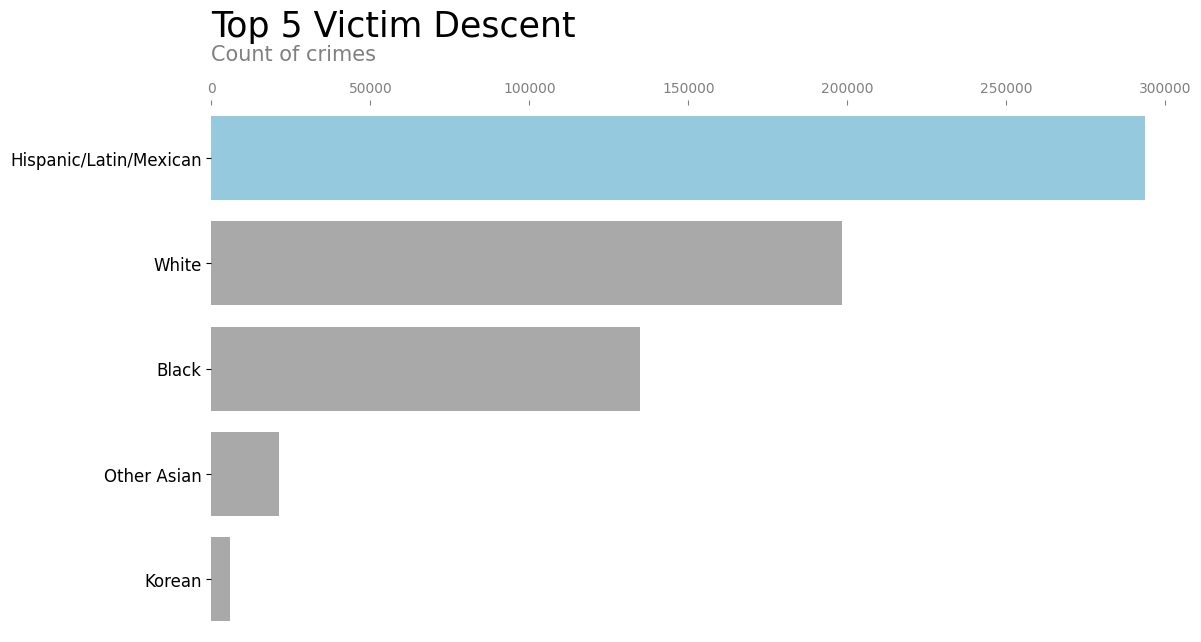

In [22]:
victdescent= lacrime_df['Vict Descent'][
(lacrime_df['Vict Descent']!='Other')&
(lacrime_df['Vict Descent'] !='Unknown')].value_counts().reset_index().rename(columns={'Vict Descent':'Vict',0:'count'})
hl= ['Hispanic/Latin/Mexican']
victdescent['Color Group'] = ['Highlight' if cat in hl else 'Normal' for cat in victdescent['Vict']]
q9= sns.catplot(data=victdescent.head(), y='Vict',x='count',kind='bar',height=6,aspect=2,hue='Color Group',
               palette={'Highlight': 'skyblue', 'Normal': 'darkgrey'},legend=False)
plt.title('Top 5 Victim Descent',fontsize=25,loc='left')
sns.despine(left=True, bottom=True)
q9.set(ylabel=None)
for ax in q9.axes.flat:
    ax.set_xlabel('Count of crimes', fontsize=15, labelpad=15,loc='left',color='grey')
    ax.xaxis.set_label_position('top')
q9.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False,color='grey',labelcolor='grey')
plt.yticks(fontsize=12)
plt.show()

#### Description

This breakdown provides deeper insights into cultural and socioeconomic factors possibly affecting crime rates within specific communities, especially in the hispanic community. This could help to direct social services and safety initiatives. 

### Question 10: What are the statuses of the reported crime?

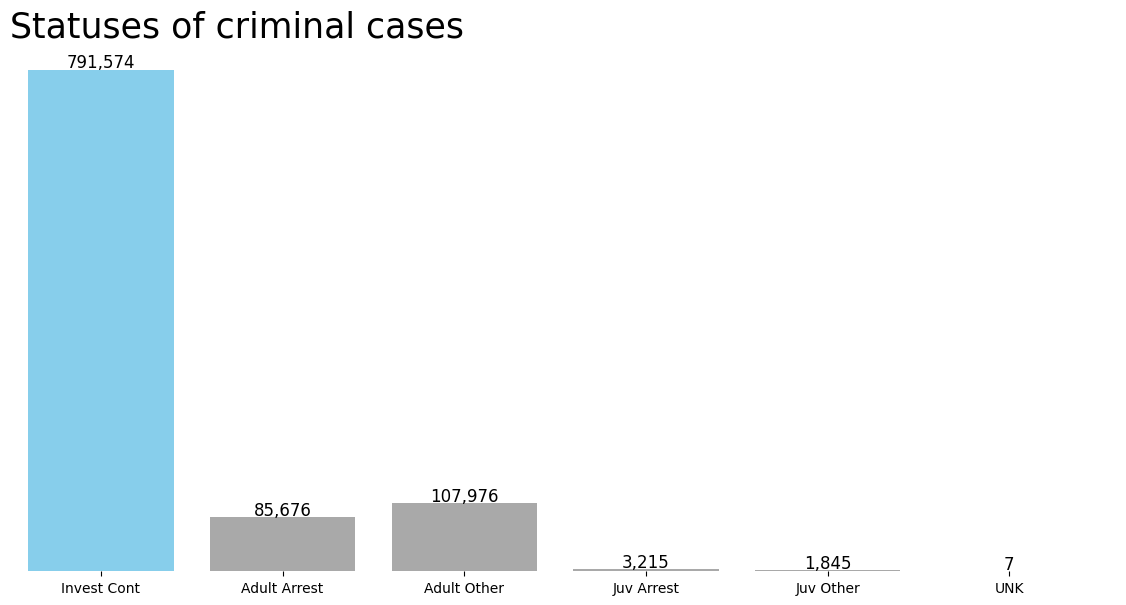

In [23]:
status_order=['Invest Cont','Adult Arrest','Adult Other','Juv Arrest','Juv Other','UNK']
g= sns.catplot(data=lacrime_df, x='Status Desc', kind='count', height=6, aspect=2,color='darkgrey',order=status_order)
incon = g.ax.patches[0] 
incon.set_facecolor('skyblue')
plt.title('Statuses of criminal cases',fontsize=25,loc='left')
sns.despine(left=True,bottom=True)
g.set(xlabel=None)
g.set(ylabel=None)
plt.yticks(ticks=[], labels=[])
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black',
                    xytext=(0, 5), textcoords='offset points')
plt.show()

#### Description

There exists an overwhelming majority of cases marked as 'Investigation Continued.' This distribution highlights the ongoing nature of investigations and the lower frequency of resolution.

### Question 11: What year had the most crime?

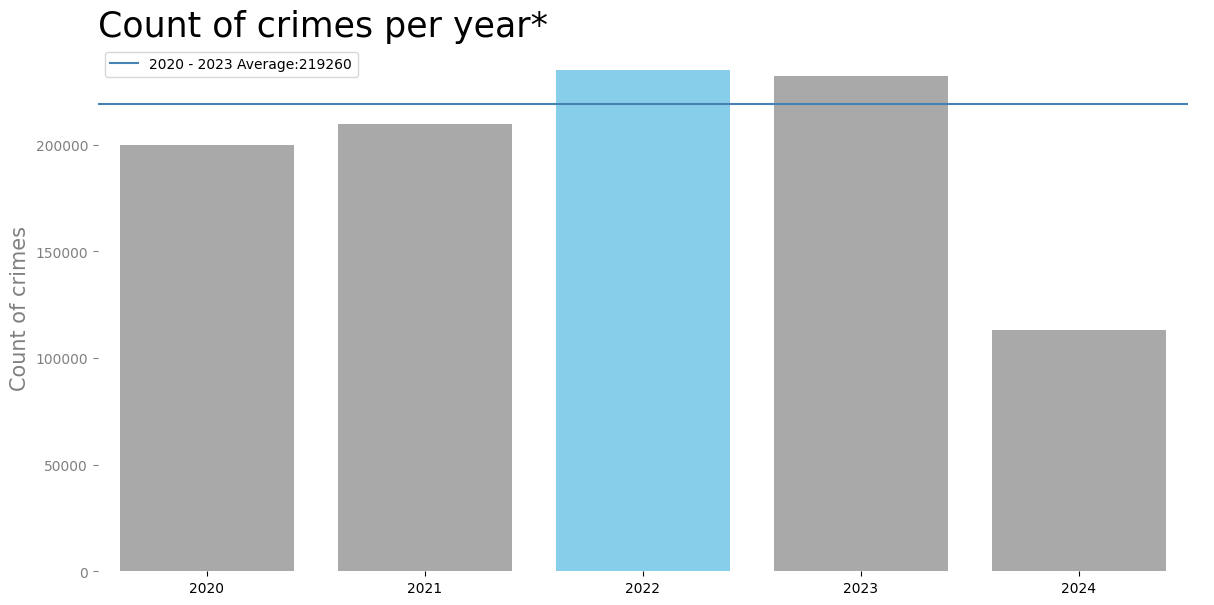

In [24]:
q11= sns.catplot(data=lacrime_df, x='Year',kind='count',height=6,aspect=2,color='darkgrey')
plt.title('Count of crimes per year*',fontsize=25,loc='left')
top = q11.ax.patches[2] 
top.set_facecolor('skyblue')
plt.ylabel('Count of crimes',fontsize=15,color='grey')
q11.set(xlabel=None)
q11.tick_params(axis='y',colors='grey')
qq11 = q11.ax
qq11.spines['left'].set_color("grey")
sns.despine(bottom=True,left=True)
#plt.xlabel('Year',fontsize=15)
averagey= round(lacrime_df['Year'][lacrime_df['Year'] != 2024].value_counts().mean())
plt.axhline(averagey,color='steelblue',linestyle='-',label=f'2020 - 2023 Average:{averagey}')
plt.legend()
plt.show()

#### Description
The data shows a slight increase in reported crimes since 2020, with a peak in 2022. This could be related to the pandemic and could provide context for the change in crimes.
<br>
*At the time of the analysis 2024 data was incomplete.

## Exploratory Data Analysis

For those interested in the steps I took in understanding the data, the following sections contain a more in depth explanation of the code.

### LA crime data 2020 to present

https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8/about_data

The data used in this analysis is found in the website above. The webiste includes a detailed description of the column headers.

In [25]:
# Reading in the same data under a new name to show steps taken to create charts
lacrime= pd.read_csv("C:/Users/perez/Downloads/Crime_Data_from_2020_to_Present_2024.csv")

In [26]:
# We first look at how much information we have and the column names of the dataframe
# We can see some of these columns contain a lot of null values
lacrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990293 entries, 0 to 990292
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           990293 non-null  int64  
 1   Date Rptd       990293 non-null  object 
 2   DATE OCC        990293 non-null  object 
 3   TIME OCC        990293 non-null  int64  
 4   AREA            990293 non-null  int64  
 5   AREA NAME       990293 non-null  object 
 6   Rpt Dist No     990293 non-null  int64  
 7   Part 1-2        990293 non-null  int64  
 8   Crm Cd          990293 non-null  int64  
 9   Crm Cd Desc     990293 non-null  object 
 10  Mocodes         842641 non-null  object 
 11  Vict Age        990293 non-null  int64  
 12  Vict Sex        849515 non-null  object 
 13  Vict Descent    849504 non-null  object 
 14  Premis Cd       989970 non-null  float64
 15  Premis Desc     989399 non-null  object 
 16  Weapon Used Cd  326547 non-null  float64
 17  Weapon Des

In [27]:
# Looking at the values of the first 5 rows
lacrime.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


Looking through the data and knowing the questions posed there are columns that won't be used in this analysis. Some of the columns are redundant as they provide a code used to identify a weapon or specific crime, but don't help give insight as to what it means. In the next step we drop all of those columns.

In [28]:
# Dropping columns of information that aren't used in this analysis
lacrime.drop(['Crm Cd 1','Crm Cd 2','Crm Cd 3','Crm Cd 4','Cross Street','Status',
                 'LAT','LON','Weapon Used Cd','Mocodes','Part 1-2'],axis=1,inplace=True)

### Crimes

In [29]:
# Let's look at the unique values of the reported crimes
lacrime['Crm Cd Desc'].unique()

array(['VEHICLE - STOLEN', 'BURGLARY FROM VEHICLE', 'BIKE - STOLEN',
       'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)', 'THEFT OF IDENTITY',
       'BATTERY - SIMPLE ASSAULT',
       'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
       'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'CRIMINAL THREATS - NO WEAPON DISPLAYED',
       'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
       'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
       'CHILD ANNOYING (17YRS & UNDER)',
       'THEFT PLAIN - PETTY ($950 & UNDER)', 'LEWD CONDUCT',
       'THEFT PLAIN - ATTEMPT', 'BURGLARY',
       'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
       'BATTERY WITH SEXUAL CONTACT', 'INTIMATE PARTNER - SIMPLE ASSAULT',
       'ROBBERY', 'BUNCO, GRAND THEFT',
       'INTIMATE PARTNER - AGGRAVA

There are over 100 unique crimes committed. Although many of the crimes seem similar, California and the LAPD have distinctions between crimes. For example grand theft insurance fraud and grand theft auto repair fall under seperate crimes.

In [30]:
# We can see an ordered list of how many times crimes have been reported
lacrime['Crm Cd Desc'].value_counts()

Crm Cd Desc
VEHICLE - STOLEN                                           112502
BATTERY - SIMPLE ASSAULT                                    74747
BURGLARY FROM VEHICLE                                       61944
THEFT OF IDENTITY                                           61413
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     60082
                                                            ...  
FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)              5
FIREARMS RESTRAINING ORDER (FIREARMS RO)                        4
DISHONEST EMPLOYEE ATTEMPTED THEFT                              4
TRAIN WRECKING                                                  1
DRUNK ROLL - ATTEMPT                                            1
Name: count, Length: 140, dtype: int64

The count of many of the crimes are in the single digits or a significantly smaller than the rest of the values. This is why I chose to show the top 10 crimes committed.

### Weapons

In [31]:
# We can look at all of the unique weapons used in some of the crimes
lacrime['Weapon Desc'].unique()

array([nan, 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)', 'VEHICLE',
       'UNKNOWN WEAPON/OTHER WEAPON', 'VERBAL THREAT',
       'BELT FLAILING INSTRUMENT/CHAIN', 'HAND GUN', 'UNKNOWN FIREARM',
       'KNIFE WITH BLADE 6INCHES OR LESS', 'FIXED OBJECT',
       'KITCHEN KNIFE', 'MACHETE', 'UNKNOWN TYPE CUTTING INSTRUMENT',
       'MACE/PEPPER SPRAY', 'STICK', 'OTHER KNIFE', 'PHYSICAL PRESENCE',
       'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH', 'HAMMER',
       'AIR PISTOL/REVOLVER/RIFLE/BB GUN', 'SEMI-AUTOMATIC PISTOL',
       'SIMULATED GUN', 'RAZOR', 'OTHER FIREARM', 'FOLDING KNIFE',
       'PIPE/METAL PIPE', 'ROCK/THROWN OBJECT', 'RIFLE',
       'OTHER CUTTING INSTRUMENT', 'FIRE', 'REVOLVER', 'BOTTLE',
       'SCISSORS', 'SWITCH BLADE', 'BRASS KNUCKLES', 'CLUB/BAT',
       'BLUNT INSTRUMENT', 'BOARD', 'STUN GUN', 'CLEAVER', 'RAZOR BLADE',
       'SCREWDRIVER', 'SHOTGUN', 'CONCRETE BLOCK/BRICK',
       'CAUSTIC CHEMICAL/POISON', 'SEMI-AUTOMATIC RIFLE',
       'SCALDING LIQUID', 

It's interesting to see the variety of weapons used in crimes in Los Angeles. Would this list be similar all over the United States?

In [32]:
lacrime['Weapon Desc'].value_counts()

Weapon Desc
STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    174546
UNKNOWN WEAPON/OTHER WEAPON                        36087
VERBAL THREAT                                      23815
HAND GUN                                           20128
SEMI-AUTOMATIC PISTOL                               7254
                                                   ...  
MAC-11 SEMIAUTOMATIC ASSAULT WEAPON                    3
MAC-10 SEMIAUTOMATIC ASSAULT WEAPON                    2
HECKLER & KOCH 91 SEMIAUTOMATIC ASSAULT RIFLE          2
M-14 SEMIAUTOMATIC ASSAULT RIFLE                       2
M1-1 SEMIAUTOMATIC ASSAULT RIFLE                       1
Name: count, Length: 79, dtype: int64

Just like we saw with crimes, there are many weapons that aren't used frequently and are a small percentage of weapons used, hence the decison to only include the top 10. It's interesting to see strong arm and verbal threats on the list of weapons as defined by California and LAPD. For the analysis I decided not to include them in the top 10 because these aren't physical objects in markets.

### 21 Patrol Divisions

The website used to download the data informs us that the LAPD has 21 community police stations also know as patrol divisions.

In [33]:
# The 21 police divisions in LA ordered from most to least amount of crimes
lacrime['AREA NAME'].value_counts()

AREA NAME
Central        68421
77th Street    61153
Pacific        58378
Southwest      56491
Hollywood      51726
N Hollywood    50370
Olympic        49416
Southeast      49414
Newton         48558
Wilshire       47472
Rampart        46184
West LA        45031
Northeast      42263
Van Nuys       42245
West Valley    41584
Devonshire     41143
Harbor         40754
Topanga        40724
Mission        39754
Hollenbeck     36455
Foothill       32757
Name: count, dtype: int64

To make an easily digestable visual I decided to only include the top 10 of this list in the analysis. We could potentially look at the varying crimes rates per patrol division to highlight trends over time.

https://geohub.lacity.org/datasets/19a8293551974116b76533e984dd9260/about

The website above gives me the necessary geographic data to create a map of the 21 patrol divisions of Los Angeles using geopandas.

<Axes: >

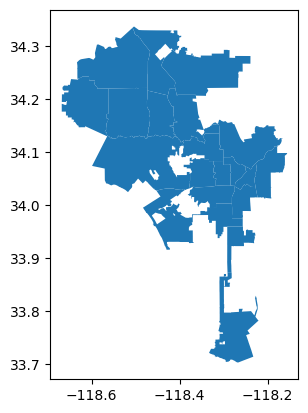

In [34]:
# An early iteration of what the geographical map looks like
lapd.plot()

### Time of day

In [35]:
# The data presents the time the crime occurred in military time
lacrime['TIME OCC']

0         2130
1         1800
2         1700
3         2037
4         1200
          ... 
990288    1400
990289     100
990290    2330
990291    1500
990292    2300
Name: TIME OCC, Length: 990293, dtype: int64

In [36]:
# Let's see what times have the most reported crimes
lacrime['TIME OCC'].value_counts().reset_index().head(10)

,TIME OCC,count
0,1200,34687
1,1800,26201
2,1700,24812
3,2000,24404
4,1900,22710
5,2200,22499
6,2100,21551
7,1600,20530
8,1500,19952
9,1400,17591


Looking at what specific times have the highest count of crimes, we see that they tend to be recorded on the hour. Could this due to indifference of actually marking down a specific time? Or is  it a coincidence? Let's take a closer look.

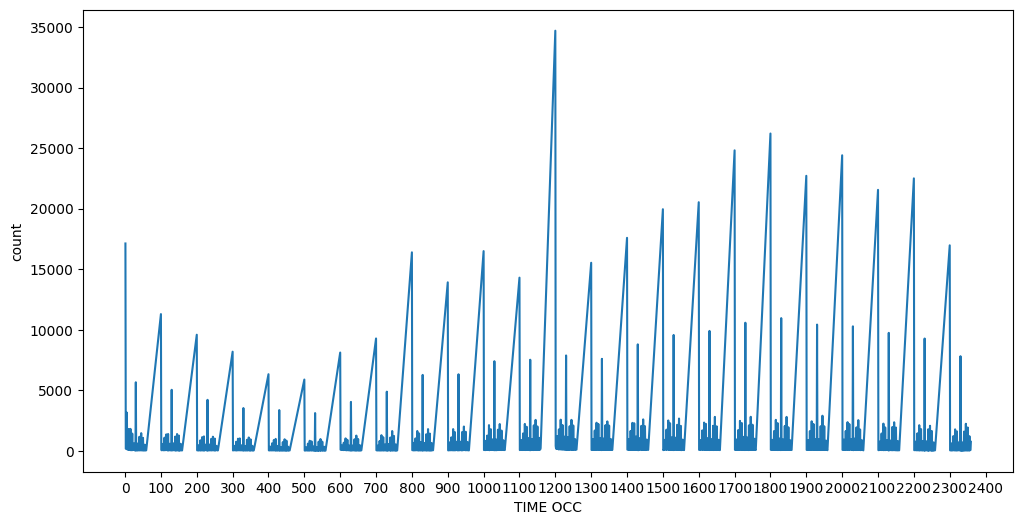

In [37]:
plt.figure(figsize=(12,6))
sns.lineplot(data=lacrime['TIME OCC'].value_counts().reset_index().sort_values(by='TIME OCC'), x='TIME OCC',y='count')
plt.xticks(range(0,2401,100))
plt.show()

The linegraph shows that there's a spike at the hourmark, every hour, with the biggest spike located at 12:00 pm. This could indicate that approximations were used rather than an exact time. The person reporting the crime or police officer could have just estimated the time the crime occurred.

In [38]:
# for the analysis I decided to divide the day into 4 equal parts
def timeofday(time):
    occ= time    
    if time >=0 and time <600:
        return 'Late night: 12am to 6am'
    if time >=600 and time <1200:
        return 'Morning: 6am to 12pm'
    if time >=1200 and time <1800:
        return 'Afternoon: 12pm to 6pm'
    if time >=1800 and time <2359:
        return 'Evening/Night: 6pm to 12am'       
# Using the function to add a new column containing time of day from time crime occurred
lacrime['Time Crime Occ']= lacrime['TIME OCC'].apply(timeofday)

In [39]:
# using this new column we get a better visual, in the analysis, than the one we had earlier, although more general it's easier to understand
lacrime['Time Crime Occ']

0         Evening/Night: 6pm to 12am
1         Evening/Night: 6pm to 12am
2             Afternoon: 12pm to 6pm
3         Evening/Night: 6pm to 12am
4             Afternoon: 12pm to 6pm
                     ...            
990288        Afternoon: 12pm to 6pm
990289       Late night: 12am to 6am
990290    Evening/Night: 6pm to 12am
990291        Afternoon: 12pm to 6pm
990292    Evening/Night: 6pm to 12am
Name: Time Crime Occ, Length: 990293, dtype: object

### Days of the week

In [40]:
# Let's take a look at the dates the crimes occurred
lacrime['DATE OCC']

0         03/01/2020 12:00:00 AM
1         02/08/2020 12:00:00 AM
2         11/04/2020 12:00:00 AM
3         03/10/2020 12:00:00 AM
4         08/17/2020 12:00:00 AM
                   ...          
990288    07/23/2024 12:00:00 AM
990289    01/15/2024 12:00:00 AM
990290    10/11/2024 12:00:00 AM
990291    04/24/2024 12:00:00 AM
990292    08/12/2024 12:00:00 AM
Name: DATE OCC, Length: 990293, dtype: object

We can turn this into more useful information by knowing what day of the week the crime occurred.

In [41]:
# Adding a new column, day of the week the crime occurred
lacrime['DATE OCC']= pd.to_datetime(lacrime['DATE OCC'], format="%m/%d/%Y %I:%M:%S %p")
lacrime['Day of the Week']=lacrime['DATE OCC'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
lacrime['Day of the Week'] = pd.Categorical(lacrime['Day of the Week'], categories=weekday_order, ordered=True)

In [42]:
# Creating a new dataframe grouping by time occurred and day of the week
time_day= lacrime.groupby(['TIME OCC', 'Day of the Week'],observed=False).size().reset_index(name='count')

In [43]:
# There's potential to see a more insightful visual highlighting specific times in days of the week that have higher crime rates
time_day

,TIME OCC,Day of the Week,count
0,1,Monday,2521
1,1,Tuesday,2274
2,1,Wednesday,2416
3,1,Thursday,2325
4,1,Friday,2482
...,...,...,...
10068,2359,Wednesday,108
10069,2359,Thursday,89
10070,2359,Friday,125
10071,2359,Saturday,120


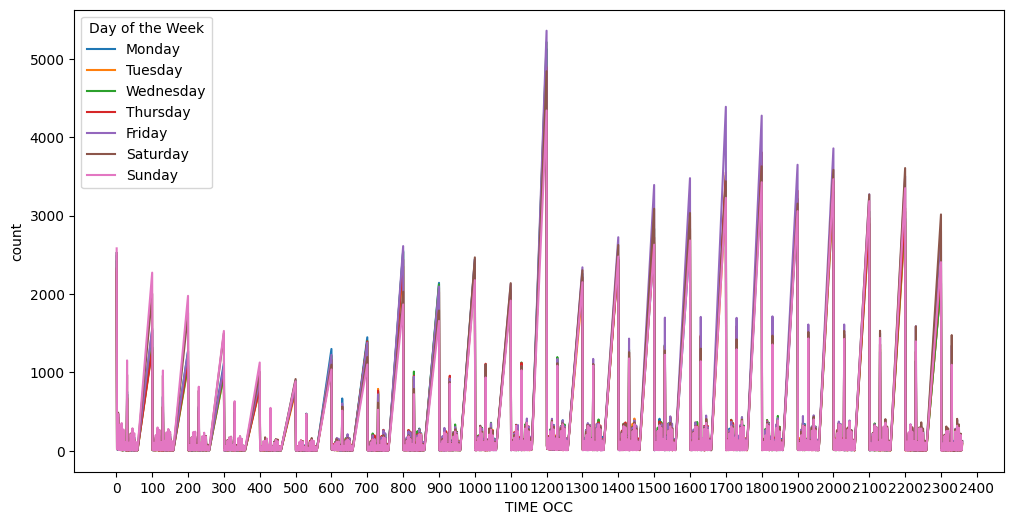

In [44]:
# an attempt to see different patterns in crime rates by days of the week
plt.figure(figsize=(12,6))
sns.lineplot(data=time_day, x='TIME OCC',
             hue='Day of the Week',y='count')
plt.xticks(range(0,2401,100))
plt.show()

Just like our visual for count of crimes by time of day, this visual is not much more insightful. 

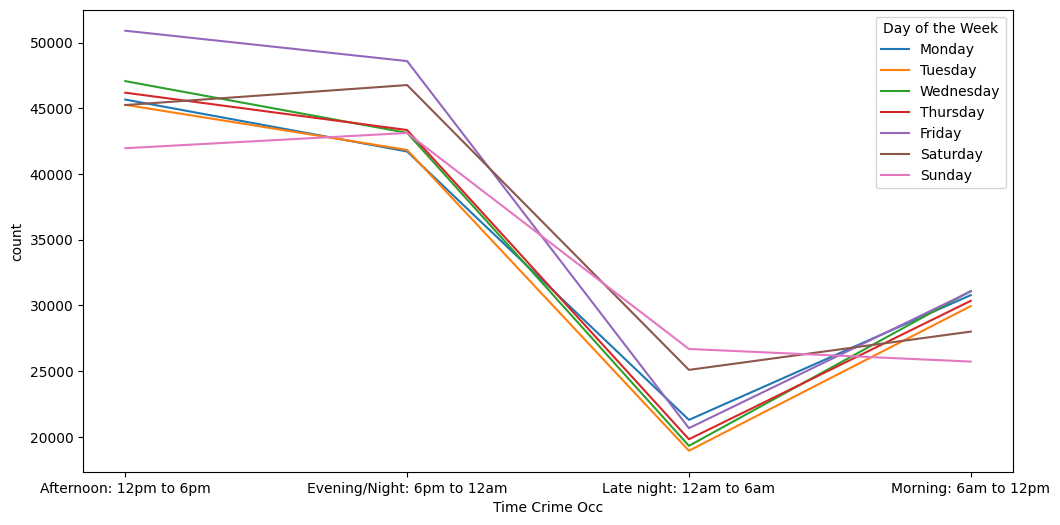

In [45]:
# This is a little better but also not the best

# Creating a new dataframe to have the count grouped by time of day and day of the week
time_day1= lacrime.groupby(['Time Crime Occ', 'Day of the Week'],observed=False).size().reset_index(name='count')
plt.figure(figsize=(12,6))
sns.lineplot(data=time_day1, x='Time Crime Occ',y='count',hue='Day of the Week',sort=False)
plt.show()

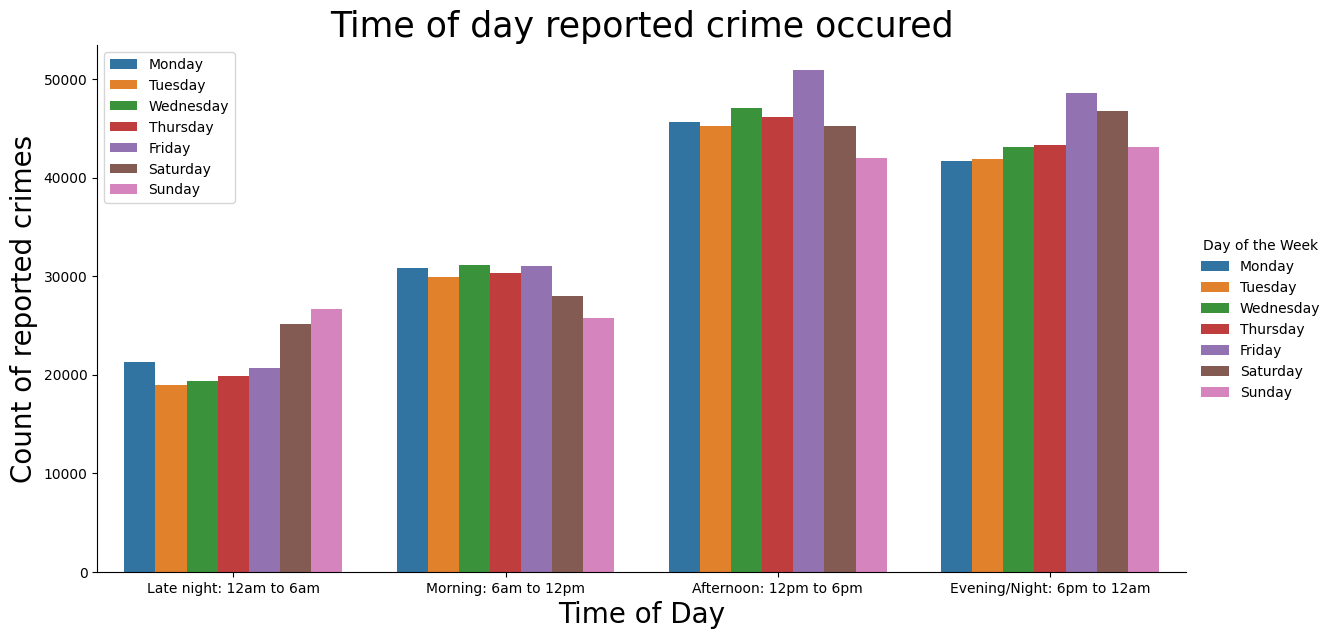

In [46]:
# Here's a third attempt to creating an insightful visual
timeorder= ['Late night: 12am to 6am','Morning: 6am to 12pm','Afternoon: 12pm to 6pm','Evening/Night: 6pm to 12am']
sns.catplot(data=lacrime,x='Time Crime Occ',hue='Day of the Week',kind='count',height=6,aspect=2,order=timeorder)
plt.title('Time of day reported crime occured',fontsize=25)
plt.ylabel('Count of reported crimes',fontsize=20)
plt.xlabel('Time of Day',fontsize=20)
plt.legend()
plt.show()

Though this is a better graph than the previous iteration, it's not clearest graph we could present. In the analysis I decided to give a simplier view at what days of the week have a higher crime rate.

### Victim Sex

In [47]:
# First we look at the different possibles sexes for this data
lacrime['Vict Sex'].unique()

array(['M', 'X', 'F', nan, 'H', '-'], dtype=object)

We know that F is for female, M is for male, and X is for unknown. We'll take a look at what these unknown variables could mean.

In [48]:
lacrime.loc[lacrime['Vict Sex']=='-']

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Desc,Status Desc,LOCATION,Time Crime Occ,Day of the Week
807561,232012240,06/29/2023 12:00:00 AM,2023-06-29,2115,20,Olympic,2091,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,-,-,408.0,AUTO SUPPLY STORE*,NaN,Invest Cont,1900 S WESTERN AV,Evening/Night: 6pm to 12am,Thursday


In this specific case vandalism doesn't necessarily have a victim and therefore we have a - for sex.

In [49]:
lacrime.loc[lacrime['Vict Sex']=='H'].head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Desc,Status Desc,LOCATION,Time Crime Occ,Day of the Week
17629,200714556,10/05/2020 12:00:00 AM,2020-10-05,200,7,Wilshire,769,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",35,H,H,101.0,STREET,PIPE/METAL PIPE,Invest Cont,15TH ST,Late night: 12am to 6am,Monday
21750,200708374,04/14/2020 12:00:00 AM,2020-04-14,1300,7,Wilshire,721,330,BURGLARY FROM VEHICLE,33,H,F,101.0,STREET,NaN,Invest Cont,8500 COLGATE AV,Afternoon: 12pm to 6pm,Tuesday
30536,202017825,11/29/2020 12:00:00 AM,2020-11-29,1530,20,Olympic,2088,626,INTIMATE PARTNER - SIMPLE ASSAULT,25,H,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)","STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,1600 ARAPAHOE ST,Afternoon: 12pm to 6pm,Sunday
38080,200204197,01/03/2020 12:00:00 AM,2020-01-03,2200,2,Rampart,237,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",25,H,F,103.0,ALLEY,NaN,Invest Cont,1600 W 2ND ST,Evening/Night: 6pm to 12am,Friday
57093,201310830,05/13/2020 12:00:00 AM,2020-05-09,1716,13,Newton,1322,440,THEFT PLAIN - PETTY ($950 & UNDER),49,H,F,145.0,MAIL BOX,NaN,Invest Cont,2300 WALL ST,Afternoon: 12pm to 6pm,Saturday


In some cases there isn't victim for H and in others it's not very clear what the H represents, that's why it will be added to the unknown category.

In [50]:
# Adjusting Victim Sex column to fill in unknowns and nonapplicables with 'X'
lacrime['Vict Sex']=lacrime['Vict Sex'].replace('H','X')
lacrime['Vict Sex']=lacrime['Vict Sex'].replace('-','X')
lacrime['Vict Sex']= lacrime['Vict Sex'].fillna('X')
lacrime['Vict Sex']=lacrime['Vict Sex'].replace('F','Female')
lacrime['Vict Sex']=lacrime['Vict Sex'].replace('M','Male')

### Victim Age

In [51]:
# Let's look at the amount of victims per age 
lacrime['Vict Age'].value_counts()

Vict Age
 0      263194
 30      21998
 35      21516
 31      21133
 29      21066
         ...  
 98         71
-2          27
-3           5
-4           3
 120         1
Name: count, Length: 104, dtype: int64

We see age 0 is has the most amount of victims. There are a couple cases where age is negative, and 120 stands out as an outlier. Let's take a close look.

In [52]:
# Looking at some of the crime descriptions for victim age 120
lacrime[lacrime['Vict Age'] ==120]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Desc,Status Desc,LOCATION,Time Crime Occ,Day of the Week
196639,200808494,04/19/2020 12:00:00 AM,2020-04-19,2145,8,West LA,889,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",120,X,NaN,101.0,STREET,SEMI-AUTOMATIC PISTOL,Invest Cont,2000 S BEDFORD ST,Evening/Night: 6pm to 12am,Sunday


In [53]:
# Looking at some of the crime descriptions for victim age 0
lacrime[lacrime['Vict Age'] ==0]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Desc,Status Desc,LOCATION,Time Crime Occ,Day of the Week
0,190326475,03/01/2020 12:00:00 AM,2020-03-01,2130,7,Wilshire,784,510,VEHICLE - STOLEN,0,Male,O,101.0,STREET,NaN,Adult Arrest,1900 S LONGWOOD AV,Evening/Night: 6pm to 12am,Sunday
13,221008844,05/06/2022 12:00:00 AM,2020-11-01,130,10,West Valley,1029,510,VEHICLE - STOLEN,0,X,NaN,101.0,STREET,NaN,Invest Cont,VALJEAN ST,Late night: 12am to 6am,Sunday
23,200412582,09/09/2020 12:00:00 AM,2020-09-09,630,4,Hollenbeck,413,510,VEHICLE - STOLEN,0,X,NaN,101.0,STREET,NaN,Invest Cont,200 E AVENUE 28,Morning: 6am to 12pm,Wednesday
26,222106031,02/23/2022 12:00:00 AM,2020-08-14,1300,21,Topanga,2113,668,"EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)",0,X,NaN,203.0,OTHER BUSINESS,NaN,Invest Cont,7700 SAUSALITO AV,Afternoon: 12pm to 6pm,Friday
27,200209713,05/03/2020 12:00:00 AM,2020-05-02,1800,2,Rampart,245,510,VEHICLE - STOLEN,0,X,NaN,101.0,STREET,NaN,Invest Cont,2500 W 4TH ST,Evening/Night: 6pm to 12am,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990274,241406728,02/29/2024 12:00:00 AM,2024-02-28,100,14,Pacific,1415,510,VEHICLE - STOLEN,0,X,NaN,101.0,STREET,NaN,Invest Cont,1300 APPLETON WY,Late night: 12am to 6am,Wednesday
990280,241513941,09/20/2024 12:00:00 AM,2024-09-16,1800,15,N Hollywood,1523,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0,X,NaN,101.0,STREET,NaN,Invest Cont,6100 WHITSETT AV,Evening/Night: 6pm to 12am,Monday
990288,240710284,07/24/2024 12:00:00 AM,2024-07-23,1400,7,Wilshire,788,510,VEHICLE - STOLEN,0,X,NaN,101.0,STREET,NaN,Invest Cont,4000 W 23RD ST,Afternoon: 12pm to 6pm,Tuesday
990289,240104953,01/15/2024 12:00:00 AM,2024-01-15,100,1,Central,101,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0,X,X,503.0,HOTEL,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,1300 W SUNSET BL,Late night: 12am to 6am,Monday


In [54]:
# Looking at some of the crime descriptions for victim age 1 to compare to age 0
lacrime[lacrime['Vict Age'] ==1]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Desc,Status Desc,LOCATION,Time Crime Occ,Day of the Week


In [55]:
# Looking at some of the crime descriptions for victim age 2 to compare to age 0
lacrime[lacrime['Vict Age'] ==2]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Desc,Status Desc,LOCATION,Time Crime Occ,Day of the Week
686,231805325,01/26/2023 12:00:00 AM,2020-01-01,1200,18,Southeast,1834,812,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,2,Male,B,501.0,SINGLE FAMILY DWELLING,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,700 E 108TH ST,Afternoon: 12pm to 6pm,Wednesday
722,221806711,02/28/2022 12:00:00 AM,2020-01-01,700,18,Southeast,1822,815,SEXUAL PENETRATION W/FOREIGN OBJECT,2,Female,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)","STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,10300 S MAIN ST,Morning: 6am to 12pm,Wednesday
1460,221407878,03/19/2022 12:00:00 AM,2020-01-01,1,14,Pacific,1409,815,SEXUAL PENETRATION W/FOREIGN OBJECT,2,Male,A,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)","STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,3600 FARIS DR,Late night: 12am to 6am,Wednesday
1687,231117119,12/13/2023 12:00:00 AM,2020-01-01,1,11,Northeast,1144,812,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,2,Female,W,501.0,SINGLE FAMILY DWELLING,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,2000 MICHELTORENA ST,Late night: 12am to 6am,Wednesday
2654,200111785,05/16/2020 12:00:00 AM,2020-05-16,1150,1,Central,154,624,BATTERY - SIMPLE ASSAULT,2,Male,B,102.0,SIDEWALK,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,500 S MAIN ST,Morning: 6am to 12pm,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970900,240505211,01/31/2024 12:00:00 AM,2024-01-31,1200,5,Harbor,504,901,VIOLATION OF RESTRAINING ORDER,2,Male,W,231.0,DAY CARE/CHILDREN*,NaN,Invest Cont,21100 DALTON AV,Afternoon: 12pm to 6pm,Wednesday
971935,241205927,01/31/2024 12:00:00 AM,2024-01-31,1820,12,77th Street,1267,250,"SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT",2,Male,B,108.0,PARKING LOT,HAND GUN,Adult Arrest,8500 S FIGUEROA ST,Evening/Night: 6pm to 12am,Wednesday
975579,241807311,03/10/2024 12:00:00 AM,2024-03-10,1200,18,Southeast,1862,237,CHILD NEGLECT (SEE 300 W.I.C.),2,Female,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Adult Other,12000 S MAIN ST,Afternoon: 12pm to 6pm,Sunday
975821,240506539,03/06/2024 12:00:00 AM,2024-03-06,1410,5,Harbor,566,237,CHILD NEGLECT (SEE 300 W.I.C.),2,Male,B,501.0,SINGLE FAMILY DWELLING,NaN,Invest Cont,300 W 11TH ST,Afternoon: 12pm to 6pm,Wednesday


There is a huge discrepancy in crime rates for victims aged 0, 1, and 2. It seems as if the LAPD uses 0 for instances where age may be nonapplicable. On the flipside some of these instances would actually have a victim of 0 years old. Referring back to the list of crime descriptions, we can see that some of the crimes involve a minor. Let's take a look at crimes that include words such as "child" and "minor" in the crime description and where victim age is 0.

In [56]:
# Finds instances where victim age is 0 and contains child, minor, or chld in the crime description
lacrime[(lacrime['Vict Age'] ==0)&(lacrime['Crm Cd Desc'].str.contains(r'child|minor|chld', case=False, na=False))]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Desc,Status Desc,LOCATION,Time Crime Occ,Day of the Week
1324,231008957,05/09/2023 12:00:00 AM,2020-01-09,1,10,West Valley,1028,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,0,Male,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)","STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,16500 VANOWEN ST,Late night: 12am to 6am,Thursday
2146,202007827,03/22/2020 12:00:00 AM,2020-03-22,1820,20,Olympic,2013,760,LEWD/LASCIVIOUS ACTS WITH CHILD,0,X,X,102.0,SIDEWALK,OTHER KNIFE,Invest Cont,100 S OXFORD AV,Evening/Night: 6pm to 12am,Sunday
3176,201016369,12/25/2020 12:00:00 AM,2020-12-24,2200,10,West Valley,1001,235,CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT,0,X,X,501.0,SINGLE FAMILY DWELLING,UNKNOWN WEAPON/OTHER WEAPON,Adult Arrest,19000 INGOMAR ST,Evening/Night: 6pm to 12am,Thursday
3601,200411934,08/19/2020 12:00:00 AM,2020-08-19,1940,4,Hollenbeck,491,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,0,Male,H,203.0,OTHER BUSINESS,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,1300 S SOTO ST,Evening/Night: 6pm to 12am,Wednesday
4168,200505526,02/05/2020 12:00:00 AM,2020-02-05,2200,5,Harbor,503,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,0,Female,H,501.0,SINGLE FAMILY DWELLING,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,900 BAYVIEW LN,Evening/Night: 6pm to 12am,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986084,241011365,09/25/2024 12:00:00 AM,2024-06-15,1200,10,West Valley,1065,237,CHILD NEGLECT (SEE 300 W.I.C.),0,Male,O,501.0,SINGLE FAMILY DWELLING,NaN,Invest Cont,5400 ZELZAH AV,Afternoon: 12pm to 6pm,Saturday
986543,241404153,01/04/2024 12:00:00 AM,2024-01-04,1130,14,Pacific,1483,237,CHILD NEGLECT (SEE 300 W.I.C.),0,Female,W,501.0,SINGLE FAMILY DWELLING,NaN,Adult Arrest,9400 LA TIJERA BL,Morning: 6am to 12pm,Thursday
987504,240304935,01/17/2024 12:00:00 AM,2024-01-16,700,3,Southwest,376,235,CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT,0,Female,H,501.0,SINGLE FAMILY DWELLING,SCALDING LIQUID,Invest Cont,1400 W 39TH ST,Morning: 6am to 12pm,Tuesday
990038,241214286,07/19/2024 12:00:00 AM,2024-07-19,700,12,77th Street,1208,922,CHILD STEALING,0,X,X,501.0,SINGLE FAMILY DWELLING,NaN,Invest Cont,700 W 47TH ST,Morning: 6am to 12pm,Friday


Because we saw there were 0 cases of where the victim age was 1, we may not be able to leave victim age for these cases equal to 0. It's possible that LAPD officers fill in an age with discretion when a minor is involved. We could however include these cases in the age group "minors". Before we make any changes, we can look for instances where the crime description contains "child" or "minor" and age is negative.

In [57]:
# Finds instances where victim age is negative and contains child, minor, or chld in the crime description
lacrime[(lacrime['Vict Age'] <0)&(lacrime['Crm Cd Desc'].str.contains(r'child|minor|chld', case=False, na=False))]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Desc,Status Desc,LOCATION,Time Crime Occ,Day of the Week
407313,241310972,07/01/2024 12:00:00 AM,2021-01-01,1200,13,Newton,1313,812,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,-2,Female,H,501.0,SINGLE FAMILY DWELLING,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,SANTA MONICA FY,Afternoon: 12pm to 6pm,Friday


There seems to be only one case where age is negative and the crime description describes the victim as a minor. Let's look at the other negative age cases.

In [58]:
# Looking at count of instances where victim age is negative
lacrime.loc[lacrime['Vict Age'] < 0]['Vict Age'].value_counts()

Vict Age
-1    96
-2    27
-3     5
-4     3
Name: count, dtype: int64

There are 4 unique ages that are less than 0.

In [59]:
# Looking at some of the crime descriptions for negative victim ages
lacrime[(lacrime['Vict Age'] <0)&(lacrime['Vict Sex']=='X')]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Desc,Status Desc,LOCATION,Time Crime Occ,Day of the Week
142,231806653,06/12/2022 12:00:00 AM,2020-03-04,800,18,Southeast,1832,946,OTHER MISCELLANEOUS CRIME,-2,X,X,726.0,POLICE FACILITY,NaN,Invest Cont,100 W 108TH ST,Morning: 6am to 12pm,Wednesday
595,221404829,01/18/2022 12:00:00 AM,2020-07-16,300,14,Pacific,1487,310,BURGLARY,-1,X,X,203.0,OTHER BUSINESS,NaN,Invest Cont,8600 S SEPULVEDA BL,Late night: 12am to 6am,Thursday
618,221810106,04/24/2022 12:00:00 AM,2020-11-18,1,18,Southeast,1841,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,-1,X,X,726.0,POLICE FACILITY,NaN,Invest Cont,11200 SOUTHWEST BL,Late night: 12am to 6am,Wednesday
629,222007501,03/11/2022 12:00:00 AM,2020-03-11,1425,20,Olympic,2033,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),-1,X,X,248.0,CELL PHONE STORE,NaN,Invest Cont,3700 WILSHIRE BL,Afternoon: 12pm to 6pm,Wednesday
764,222019482,12/20/2022 12:00:00 AM,2020-12-20,1330,20,Olympic,2056,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),-1,X,X,203.0,OTHER BUSINESS,NaN,Invest Cont,1100 S VERMONT AV,Afternoon: 12pm to 6pm,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626774,240109906,03/29/2024 12:00:00 AM,2022-11-11,2216,1,Central,152,668,"EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)",-1,X,X,744.0,HIGH-RISE BUILDING,NaN,Invest Cont,600 S FIGUEROA ST,Evening/Night: 6pm to 12am,Friday
633554,240906623,03/10/2024 12:00:00 AM,2022-06-19,922,9,Van Nuys,904,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),-1,X,X,404.0,DEPARTMENT STORE,NaN,Adult Arrest,14900 RAYMER ST,Morning: 6am to 12pm,Sunday
636555,242009786,06/24/2024 12:00:00 AM,2022-10-07,1815,20,Olympic,2029,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),-1,X,X,404.0,DEPARTMENT STORE,NaN,Adult Other,600 S VIRGIL AV,Evening/Night: 6pm to 12am,Friday
654277,240708202,04/18/2024 12:00:00 AM,2023-03-31,2030,7,Wilshire,724,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),-1,X,X,415.0,THE GROVE,NaN,Invest Cont,100 THE GROVE DR,Evening/Night: 6pm to 12am,Friday


Again it seems like LAPD uses negative ages for instances where victim age may be nonapplicable. We cannot give the instances where we know a minor was involve a specific age, but we can add them to an age group. To do that we can give them an arbritrary negative age as to not skew the cases where we know the actual age.

In [60]:
# Find instances where age is less than or equal to 0 and crime description contains 'child', 'minor', or 'chld'
# and replaces age with -7, an arbritrary number, specific age can't be inferred but age group can
lacrime.loc[(lacrime['Vict Age'] <=0)&(lacrime['Crm Cd Desc'].str.contains(r'chld|child|minor', case=False, na=False)),'Vict Age']= -7

In [61]:
# Looking at some of the crime descriptions for victim age -7
lacrime[lacrime['Vict Age'] ==-7].head(3)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Desc,Status Desc,LOCATION,Time Crime Occ,Day of the Week
1324,231008957,05/09/2023 12:00:00 AM,2020-01-09,1,10,West Valley,1028,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,-7,Male,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)","STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,16500 VANOWEN ST,Late night: 12am to 6am,Thursday
2146,202007827,03/22/2020 12:00:00 AM,2020-03-22,1820,20,Olympic,2013,760,LEWD/LASCIVIOUS ACTS WITH CHILD,-7,X,X,102.0,SIDEWALK,OTHER KNIFE,Invest Cont,100 S OXFORD AV,Evening/Night: 6pm to 12am,Sunday
3176,201016369,12/25/2020 12:00:00 AM,2020-12-24,2200,10,West Valley,1001,235,CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT,-7,X,X,501.0,SINGLE FAMILY DWELLING,UNKNOWN WEAPON/OTHER WEAPON,Adult Arrest,19000 INGOMAR ST,Evening/Night: 6pm to 12am,Thursday


This shows the updated victim age for instances where we know the victim was a minor but we could not identify a specific age. Now we can create a function to split victim ages into age groups.

In [62]:
def agegroup(victim):
    age= victim    
    if age == -7 or age <18 and age > 0:
        return 'Minors: 0 to 17 y/o'
    if age > 17 and age < 27:
        return 'Young Adults:18 to 26 y/o'
    if age < 1:
        return 'X'
    if age < 55 and age >26:
        return 'Adults: 27 to 54 y/o'
    else:
        return 'Seniors: 55+ y/o'
# Using the function to add a new column Age Group from victim age
lacrime['Age Group']=lacrime['Vict Age'].apply(agegroup)
ageorder=['Minors: 0 to 17 y/o','Young Adults:18 to 26 y/o','Adults: 27 to 54 y/o','Seniors: 55+ y/o']

This function includes the cases where the victims were given the arbritrary age -7 in the "minors" age group. This is how the bar chart was created in the analysis. Now we'll see a preliminary graph of count of victims over victim age.

### Victim sex and age

In [63]:
# Looking at the count of victims per age, excluding ages 0 and lower
agez= lacrime['Vict Age'][lacrime['Vict Age'] > 0].value_counts()
agez

Vict Age
30     21998
35     21516
31     21133
29     21066
28     20728
       ...  
95        99
96        95
97        72
98        71
120        1
Name: count, Length: 99, dtype: int64

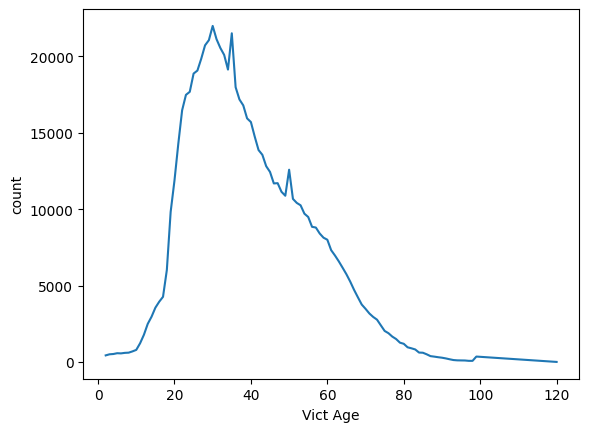

In [64]:
# Turning the sequence into a dataframe
agez_df= agez.to_frame().reset_index()
# Ordering the rows by victim age
agez_df.sort_values(by='Vict Age',inplace=True)
#preliminary graph of victim count over victim age
sns.lineplot(data=agez_df, x='Vict Age',y='count')
plt.show()

To make a more insightful and descriptive graph we had to split the sexes.

In [65]:
# Create new data frame age1z grouping victims by age and sex, and including count
age1z= lacrime.groupby(['Vict Age','Vict Sex']).size().reset_index(name='count')
age1z= age1z[(age1z['Vict Age']>0) & (age1z['Vict Sex'] != 'X')]

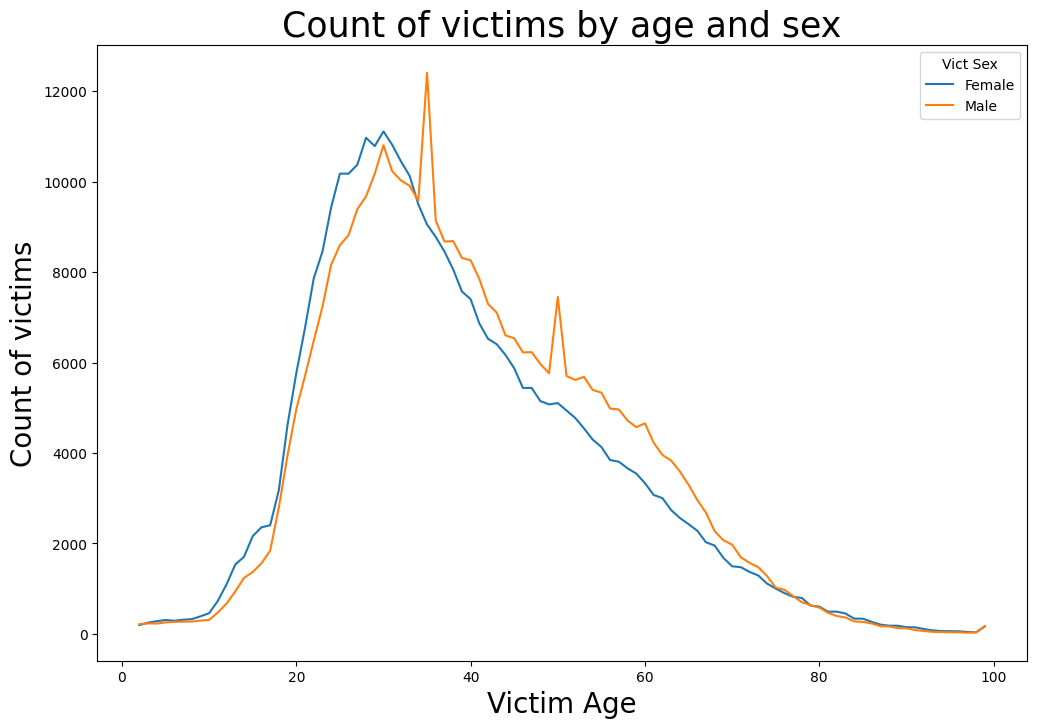

In [66]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=age1z, x='Vict Age', y='count',hue='Vict Sex')
plt.title('Count of victims by age and sex',fontsize=25)
plt.xlabel('Victim Age',fontsize=20)
plt.ylabel('Count of victims',fontsize=20)
plt.show()

We can visually see that there exist shifts in the trend at certain intersections. We also see some interesting peakes for the males and one big peak for the the females. Let's locate these points.

In [67]:
# Code used to find points of interest on the lineplot
# Separate the data by sex
female_data= age1z[age1z['Vict Sex'] == 'Female'][['Vict Age','count']].rename(columns={'count':'female_count'})
male_data= age1z[age1z['Vict Sex'] == 'Male'][['Vict Age','count']].rename(columns={'count':'male_count'})

# Merge the datasets on 'Vict Age'
merged_data= pd.merge(female_data, male_data,on='Vict Age',how='inner')

The next step is to calculate points of interest such as peaks, maxes, and intersections.

In [68]:
# Find male peaks
male_peaks, _= find_peaks(merged_data['male_count'],threshold=500)
male_peak_values= merged_data.iloc[male_peaks][['Vict Age','male_count']]

# Find the maximum for female count
female_max_value= merged_data.loc[merged_data['female_count'].idxmax()]

print("Female Max Value:\n", female_max_value)
print("Male Peak Values:\n", male_peak_values)

# Calculate the difference between male and female count
merged_data['count_diff'] = merged_data['female_count'] - merged_data['male_count']

# This multiples the value in count_diff at 1 above the index and at the index and check to see if it's negative
# If it's negative there's been a change in difference therefore intersection exists
intersection_points = merged_data[(merged_data['count_diff'].shift(1) * merged_data['count_diff']) < 0]

print("Intersection Points:\n", intersection_points[['Vict Age', 'female_count', 'male_count', 'count_diff']])

Female Max Value:
 Vict Age           30
female_count    11113
male_count      10807
Name: 28, dtype: int64
Male Peak Values:
     Vict Age  male_count
28        30       10807
33        35       12410
48        50        7451
Intersection Points:
     Vict Age  female_count  male_count  count_diff
1          3           248         233          15
32        34          9497        9581         -84
76        78           795         701          94
77        79           625         634          -9
78        80           603         582          21
97        99           168         169          -1


We now know the age of the victims for our points of interest. The highest peak for females is at age 30. The 3 big peaks for males are at ages 30, 35, and 50. The 2 places where our male and female lines intersect and indicate a shift in the trend are ages 34 and 78. Not all of this was directly presented on the graph for the final analysis.

### Victim Descent

In [69]:
# Here's a list of all the descents defined by the LAPD
replacements={'H':'Hispanic/Latin/Mexican','B':'Black','W':'White','A':'Other Asian','K':'Korean','C':'Chinese','F':'Filipino',
             'J':'Japanese','I':'American Indian/Alaskan Native','V':"Vietnamese",'S':'Samoan','P':'Pacific Islander',
             'Z':'Asian Indian','G':'Guamanian','U':'Hawaiian','D':'Cambodain','L':'Laotian','X':'Unknown','O':'Other'}
replacements

{'H': 'Hispanic/Latin/Mexican',
 'B': 'Black',
 'W': 'White',
 'A': 'Other Asian',
 'K': 'Korean',
 'C': 'Chinese',
 'F': 'Filipino',
 'J': 'Japanese',
 'I': 'American Indian/Alaskan Native',
 'V': 'Vietnamese',
 'S': 'Samoan',
 'P': 'Pacific Islander',
 'Z': 'Asian Indian',
 'G': 'Guamanian',
 'U': 'Hawaiian',
 'D': 'Cambodain',
 'L': 'Laotian',
 'X': 'Unknown',
 'O': 'Other'}

We can see the limitations of this list as it doesn't include all of the possible descents in LA.

In [70]:
lacrime['Vict Descent'].value_counts()

Vict Descent
H    293692
W    198501
B    134685
X    104534
O     77172
A     21131
K      5772
F      4643
C      4397
J      1524
V      1139
I       986
Z       544
P       280
U       212
D        88
L        74
G        72
S        56
-         2
Name: count, dtype: int64

There's a big disparity in victims per descent after the top 6. It's clearer to see a list for the top 5 in this case. Also, I decided to exclude unknown (X) and other asian (A) because it didn't help paint a clear picture of what descents make up the most amount of victims. 

### Statuses of the cases

In [71]:
# Looking at the possible values for the Status Description column
lacrime['Status Desc'].unique()

array(['Adult Arrest', 'Invest Cont', 'Adult Other', 'Juv Arrest',
       'Juv Other', 'UNK'], dtype=object)

In [72]:
lacrime['Status Desc'].value_counts()

Status Desc
Invest Cont     791574
Adult Other     107976
Adult Arrest     85676
Juv Arrest        3215
Juv Other         1845
UNK                  7
Name: count, dtype: int64

Looking at the numbers, Investigation Continued makes up the majority of the statuses of these cases. Adult other isn't defined on the webiste but could be made up of warnings, fines, and other possibilities that don't fall under arrest.

### Years

In [73]:
# Looking at the dates the crime occurred
lacrime['DATE OCC']

0        2020-03-01
1        2020-02-08
2        2020-11-04
3        2020-03-10
4        2020-08-17
            ...    
990288   2024-07-23
990289   2024-01-15
990290   2024-10-11
990291   2024-04-24
990292   2024-08-12
Name: DATE OCC, Length: 990293, dtype: datetime64[ns]

In [74]:
# Adding a new column, year crime occurred
lacrime['Year']= pd.DatetimeIndex(lacrime['DATE OCC']).year

In [75]:
lacrime['Year'].value_counts()

Year
2022    235189
2023    232216
2021    209831
2020    199806
2024    113251
Name: count, dtype: int64

We can see the count of crimes per year and it's peak is in 2022. It's important to note that 2024 is the lowest, as of November 2024. We would have to see and update once the year is over.